<a href="https://colab.research.google.com/github/malcolmrite-dsi/RockVideoClassifier/blob/main/RockClassifierCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script will show you how to read frames from a video, resize it and sample sub-images

# Mounting the Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing the Libraries

Importing the various libraries to perform the different applications needed.

In [28]:
#Viewing the images libraries
from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image
import cv2

#Handling the samples 
import numpy as np

#Displaying the graphs
import matplotlib.pyplot as plt
import seaborn as sns

#Tracking the run time of the program
import time

#Exporting the extracted images from the notification system libraries
from pathlib import Path
from PIL import Image

#Clearing the notification folder libraries
import os
import glob

#Storing the softmax values for the bin composition libraries
import pandas as pd

#Load the CNN model and run it libraries
from keras.applications.resnet50 import preprocess_input
from tensorflow import keras
from tensorflow.keras.models import Model

# Function Definitions

Code from Emile Locner: Samples the video frame with given center coordinates, the input shape of the CNN, and the window size of the sample

In [3]:
def sample_image(img, x, y, win_size, cnn_size):
  #Extracts the dimensions of the frame
  h, w, col = img.shape

  #Get the half length of the sample window
  delta = int(win_size/2)

  #Calculate the corner coordinates of the sample image
  x0 = x - delta 
  x1 = x + delta
  y0 = y - delta
  y1 = y + delta

  #If one of the corners go beyond the frame, the value is set to zero and theee window size is doubled
  if y0 < 0:
      y0 = int(0)
      y1 = int(win_size * 2)
  
  if y1 > h:
      y0 = int(h - win_size * 2)
      y1 = int(h)
  
  if x0 < 0:
      x0 = int(0)
      x1 = int(win_size * 2)
  
  if x1 > w:
      x0 = int(w - win_size * 2)
      x1 = int(w)

  #Extract the sample from the frame
  img_sample = img[y0:y1, x0:x1]

  # convert to CNN format
  img_cnn = cv2.resize(img_sample, (cnn_size,cnn_size))
  img_cnn = np.ndarray.astype(img_cnn, np.float32)
  img_cnn = np.reshape(img_cnn, (cnn_size, cnn_size, col))

  return img_cnn, [x0,x1,y0,y1]

Exports a single image from the notification system, code derived from https://realpython.com/storing-images-in-python/

In [4]:
def store_single_disk(image, image_id, label):
    """ Stores a single image as a .png file on disk.
        Parameters:
        ---------------
        image       to be stored
        image_id    integer unique ID for image
        label       image label
    """
    Image.fromarray(image).save(disk_dir / f"{image_id}.png")


Deletes all the files in a specified folder. This basically clears the notifications. Derived for Stack Overflow

In [5]:
def clearNotifications(filepath):  
  files = glob.glob(filepath + '/*')
  for f in files:
      os.remove(f)

# Preprocessing Code

This code block clears the files of a given folder

In [24]:
clearNotifications("/content/drive/My Drive/Notifications/bin_1")

Here we are loading the Keras model that will be used to classifiy the samples. A 64 x 64 ResNet50 Classifier is used as the model. Trained with 20 epochs on both training and validation data.

In [7]:
model_path = "/content/drive/My Drive/model_best_64.h5"
model = keras.models.load_model(model_path)

Creates a list that labels the output of the classifier with the appropriate label, to intepret the results. 

In [10]:
label_list = ['chip', 'fines', 'lump', 'mixed', 'pellets']

# Classifier Code

The subsampling, classification and notifications happen within this code. 

In [29]:
#Define the file path to import the video from.
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_3.mp4"

#Define the filepath to save the notification. 
disk_dir = Path("/content/drive/My Drive/Notifications/bin_3")
disk_dir.mkdir(parents=True, exist_ok=True)

cap = cv2.VideoCapture(vid_path)

#Generate the number of frames from the video.
N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# [345,355], [125,125]
sub_samples = [[225,225]]

contamFlag = 0
notifCount = 0
notifications = []

results_g = pd.DataFrame(columns = label_list)
frames_g = pd.DataFrame(columns = label_list)

#Define sampling window size and CNN window size
sample_window_size = 150
cnn_img_size = 64

tic = time.process_time()
for frame_num in range(int(N_frames)):
  has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8
  dangerCount = 0
  if has_img:
    # Images in your trainging set were monochrome
    #img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    for i, sub in enumerate(sub_samples):

      # Grab a sample from the image. X=0, Y=0 is the top left corner. X and Y indicates the center of the sample.
      x = sub[0]
      y = sub[1]
      sample, rect = sample_image(img, int(x), int(y), sample_window_size, cnn_img_size)

      # TODO: CLASSIFER CODE HERE
      
      sample = np.expand_dims(sample, axis=0)
      sample = preprocess_input(sample)
      outputs = model.predict(sample)
      labels = outputs.argmax(axis=-1)

      labels = [label_list[i] for i in labels]


      # TODO: DECIDE IF NOFITICATION FRAME SHOUD BE SAVED
      if (outputs[0,1] >= 0.9 or outputs[0,3] >= 0.9):
        contamFlag += 1
        if contamFlag == 7:
          notifCount += 1
          print("ALERT: CONTAMINATED")
          notifications.append(frame_num)
          store_single_disk(img, frame_num, notifCount)
      elif contamFlag > 24:
        contamFlag = 0

      frames_g = frames_g.append(pd.DataFrame(outputs, columns=label_list))
      # COLAB
      # - - - - - - - - - - - - 
      
      clear_output(wait=True)
      #cv2_imshow(img[rect[2]:rect[3], rect[0]:rect[1]]) 
      #cv2.waitKey(1) & 0xff
      print(labels)
      # - - - - - - - - - - - - 

      # TODO: BUILD ARRAY FOR MATERIAL COMPOSITION GRAPH
    
    results_g = results_g.append(pd.DataFrame(outputs, columns=label_list))
    


dt = time.process_time() - tic
print(dt, dt/(N_frames)) # Samples per frame should be below 150 ms




['mixed']
211.81954576600015 0.1434120147366284


In [26]:
print(dt, dt/(N_frames))
print(notifications)
print(notifCount)

197.210269123 0.13415664566190474
[120, 777, 1026, 1096, 1158, 1220, 1285, 1344]
8


# Graphing Code

This block generates the bin composition graph for the video

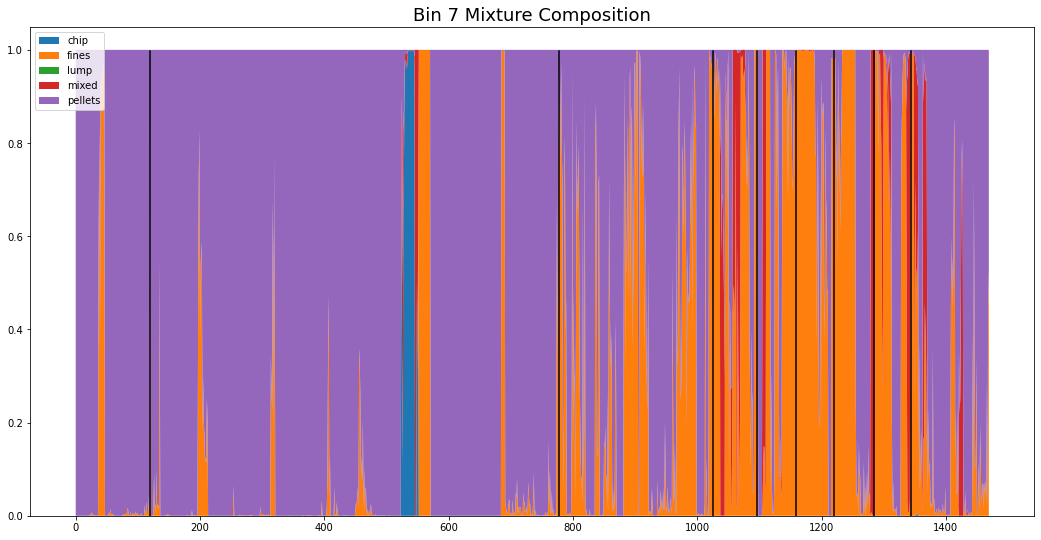

In [27]:

plt.figure(figsize=(18,9))

plt.stackplot(list(range(0, int(N_frames))), [results_g.chip, results_g.fines , results_g.lump, results_g.mixed, results_g.pellets], 
              labels=label_list,
              )
plt.title("Bin 7 Mixture Composition", {'fontsize': 18})
plt.legend(loc='upper left')
for frame in notifications:
  plt.axvline(x=frame, color = "black", label = 'Notification', ymax = 0.95, markeredgewidth = 5)

plt.show()